# **Algorithmic Trading: German Electricity Market**

In [2]:
%load_ext autoreload
%autoreload 2

import random

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import zscore, boxcox, yeojohnson
from scipy.stats.mstats import winsorize
from scipy.stats import median_abs_deviation

from utility import plot_histograms
from constants import MONTHS

pd.options.mode.chained_assignment = None

random.seed(42)
np.random.seed(42)

In [3]:
df = pd.read_csv("data.csv", index_col=["date"], parse_dates=True)
df.index.name = "Date"
df

,wind,solar,load,spread
Date,,,,
2020-01-01 00:00:00,6084.0,0.0,43915.0,38.40
2020-01-01 00:15:00,5739.0,0.0,43770.0,-105.93
2020-01-01 00:30:00,5774.0,0.0,43267.0,-1.48
2020-01-01 00:45:00,5804.0,0.0,42934.0,3.97
2020-01-01 01:00:00,5791.0,0.0,42718.0,100.09
...,...,...,...,...
2023-12-31 22:45:00,29922.0,2.0,41550.0,102.06
2023-12-31 23:00:00,29546.0,3.0,40733.0,35.24
2023-12-31 23:15:00,29204.0,3.0,39805.0,78.57


## **Data Processing**

### **Handling outliers of spread**

#### **Winsorization: Global Outlier Handling**

The spread data exhibits extreme values that can distort the distribution and negatively impact the analysis. Winsorization is an effective technique to handle such outliers by capping the extreme values to a specific percentile. 

This approach ensures that the impact of outliers is mitigated without entirely removing them, preserving the overall structure of the data while reducing skewness and kurtosis. Winsorization is particularly useful when the spread's extreme values are suspected to arise from rare but plausible events rather than errors.

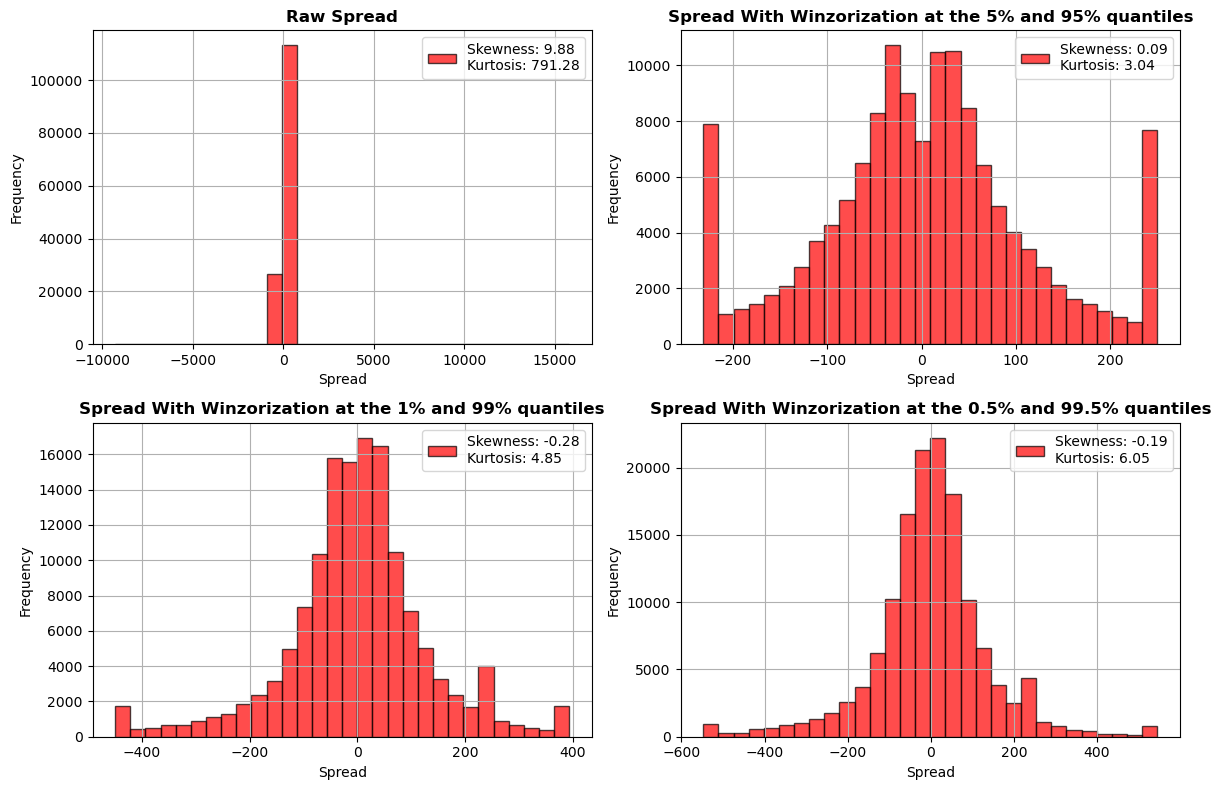

In [17]:
plot_configs_spread = {
    "spread": {
        "title": "Raw Spread",
        "label": "Spread",
        "color": "red",
        
    },
    "spread_winsorized_5_pct": {
        "title": "Spread With Winzorization at the 5% and 95% quantiles",
        "label": "Spread",
        "color": "red"
    },
    "spread_winsorized_1_pct": {
        "title": "Spread With Winzorization at the 1% and 99% quantiles",
        "label": "Spread",
        "color": "red"
    },
    "spread_winsorized_05_pct": {
        "title": "Spread With Winzorization at the 0.5% and 99.5% quantiles",
        "label": "Spread",
        "color": "red"
    }
}

spread_winsorized_5_pct = winsorize(df["spread"].copy(), limits=[0.05, 0.05])
spread_winsorized_1_pct = winsorize(df["spread"].copy(), limits=[0.01, 0.01])
spread_winsorized_05_pct = winsorize(df["spread"].copy(), limits=[0.005, 0.005])
df["spread_winsorized_5_pct"] = spread_winsorized_5_pct
df["spread_winsorized_1_pct"] = spread_winsorized_1_pct
df["spread_winsorized_05_pct"] = spread_winsorized_05_pct

plot_histograms(df[plot_configs_spread.keys()], plot_configs=plot_configs_spread)

- **5%-95% Winsorization**: Achieves the lowest skewness and kurtosis, resulting in a more symmetric appearance. However, the distribution becomes overly compressed with sharp cutoffs around ±200.

- **1%-99% Winsorization**: Balances the reduction of skewness and kurtosis while preserving the distribution's natural shape. The tails are less compressed, allowing for a better representation of moderate outliers.

- **0.5%-99.5% Winsorization**: Retains broader tails while reducing extreme outliers. This approach preserves the natural variability in the data, at the cost of a leptokurtic distribution.

**Conclusion:** The **1%-99% Winsorization** seems to be the most appropriate choice as it effectively balances the reduction of skewness and kurtosis while maintaining a reasonable and natural distribution shape. However in our case we will retain the **5%-95% Winsorization** as we care more about predicitng the direction of the spread rather than the exact level.

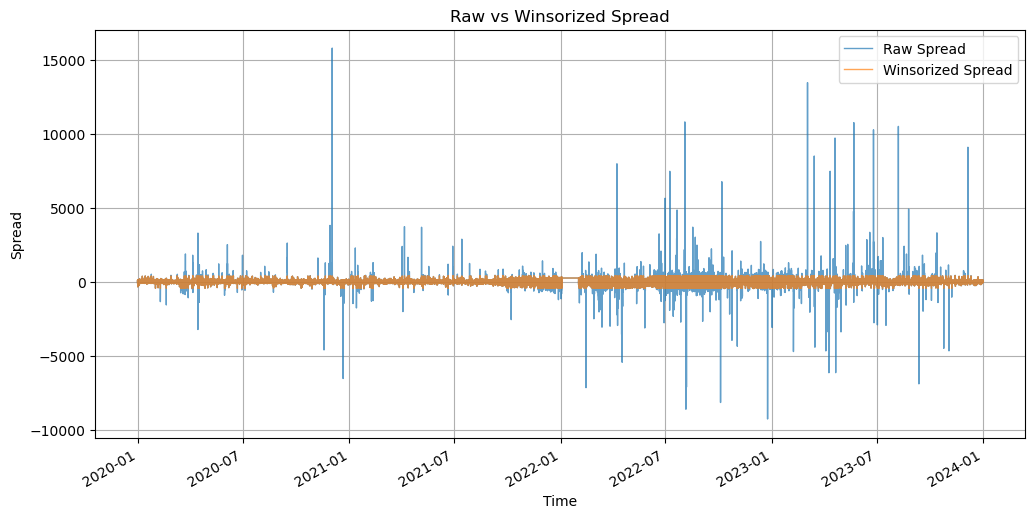

In [18]:
plt.figure(figsize=(12, 6))
df.loc["2020":, "spread"].plot(label="Raw Spread", alpha=0.7, linewidth=1)
df.loc["2020":, "spread_winsorized_1_pct"].plot(label="Winsorized Spread", alpha=0.7, linewidth=1)
plt.title("Raw vs Winsorized Spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

Winsorization effectively reduces outliers, but its global application to the entire distribution overlooks temporal differences. For instance, periods like **August 2022** exhibit significantly higher spread volatility compared to **August 2020**, highlighting the limitations of this approach in capturing regime-dependent variability.

### **Hampel Filter: A Robust Alternative**


The **Hampel Filter** offers a localized approach to outlier detection in time-series data, addressing the limitations of global methods like winsorization. By operating within a **rolling window**, it adapts to temporal variability and different regimes, preserving natural fluctuations while mitigating extreme deviations.

#### Key Features:
1. **Local Adaptation**: Outliers are identified relative to the **local median**, making the method responsive to changing trends and volatility.

2. **Robust Metrics**: Uses the **median absolute deviation (MAD)** for dispersion, resistant to extreme values.

3. **Flexible Thresholds**: Customizable thresholds (e.g., 3 MADs) allow fine-tuning for specific datasets.

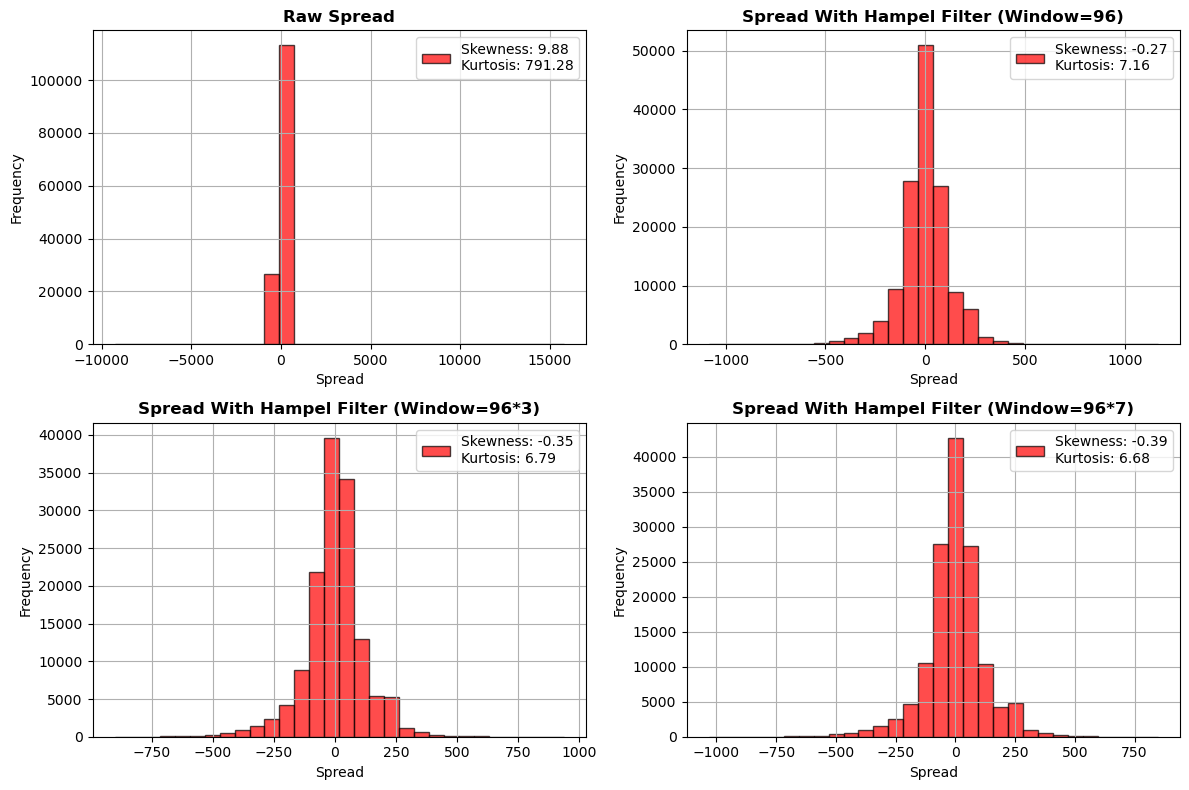

In [19]:
def apply_hampel_filter(series, window_size, n_sigmas):
    """
    Applies the Hampel filter to a time-series.

    Args:
        series (pd.Series): The time series to filter.
        window_size (int): Size of the rolling window.
        n_sigmas (float): Threshold for identifying outliers (based on MAD).

    Returns:
        pd.Series: The filtered time series.
    """
    rolling_median = series.rolling(window=window_size, center=True).median()
    mad = series.rolling(window=window_size, center=True).apply(median_abs_deviation)
    threshold = n_sigmas * mad
    outliers = (series - rolling_median).abs() > threshold
    filtered_series = series.copy()
    filtered_series[outliers] = rolling_median[outliers]
    return filtered_series

df["spread_hampel_1d"] = apply_hampel_filter(df["spread"], window_size=96*1, n_sigmas=3)
df["spread_hampel_3d"] = apply_hampel_filter(df["spread"], window_size=96*3, n_sigmas=3)
df["spread_hampel_7d"] = apply_hampel_filter(df["spread"], window_size=96*7, n_sigmas=3)

plot_configs_hampel = {
    "spread": {
        "title": "Raw Spread",
        "label": "Spread",
        "color": "red",
    },
    "spread_hampel_1d": {
        "title": "Spread With Hampel Filter (Window=96)",
        "label": "Spread",
        "color": "red",
    },
    "spread_hampel_3d": {
        "title": "Spread With Hampel Filter (Window=96*3)",
        "label": "Spread",
        "color": "red",
    },
    "spread_hampel_7d": {
        "title": "Spread With Hampel Filter (Window=96*7)",
        "label": "Spread",
        "color": "red",
    },
}

hampel_cols = ["spread_hampel_1d", "spread_hampel_3d", "spread_hampel_7d"]
plot_histograms(df[plot_configs_hampel.keys()], plot_configs=plot_configs_hampel)

- The **1-day window** (96 intervals) reduces outliers but retains more short-term variability, resulting in the highest kurtosis among the filtered versions.

- The **3-day and 7-day windows** yield similar distributions, with reduced skewness and kurtosis, providing a reasonable balance between smoothing and preserving meaningful variability.

For now, we arbitrarily select the **3-day window** as it offers a balance between local variability and smoothing without over-simplifying the data.

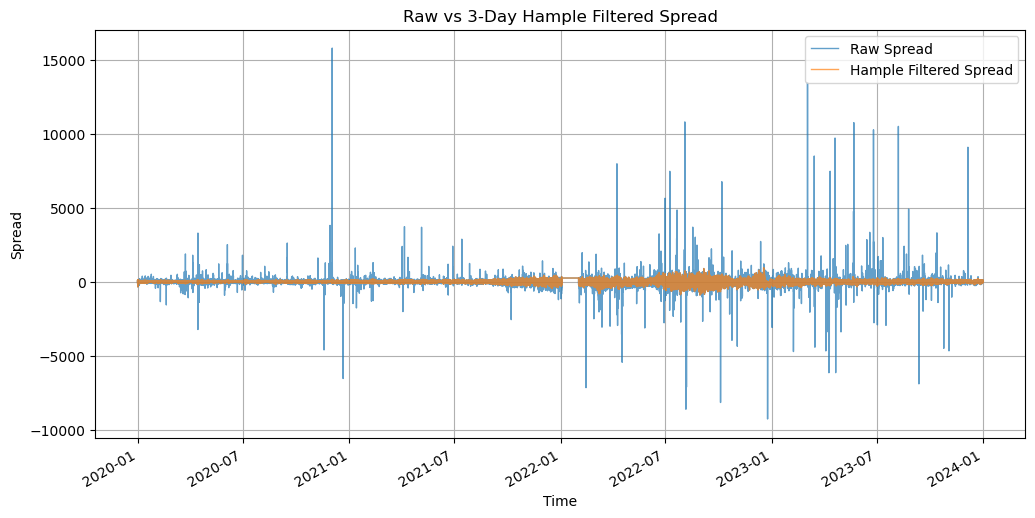

In [20]:
plt.figure(figsize=(12, 6))
df["spread"].plot(label="Raw Spread", alpha=0.7, linewidth=1)
df[hampel_cols[1]].plot(label="Hample Filtered Spread", alpha=0.7, linewidth=1)
plt.title("Raw vs 3-Day Hample Filtered Spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

As we can see the fileterd spread has a broader range during **2022** whereas for the next year the range is considerably reduced.

### **Data Transformation of Wind: Log vs Square root vs Box-Cox**

To normalize the positively skewed distribution of wind data, three transformation methods were evaluated: Log, Square Root, and Box-Cox which address the skweness in the distribution differently. The choice of transformation depends on balancing skewness reduction and preserving data interpretability.

### **Log Transformation**

The log transformation reduces positive skewness by compressing large values and is only available for stricly positive data. Applied to wind data, there is no need to apply a small constant adjustment since all the values are positive.

In [21]:
np.sum(df["wind"] == 0)

np.int64(0)

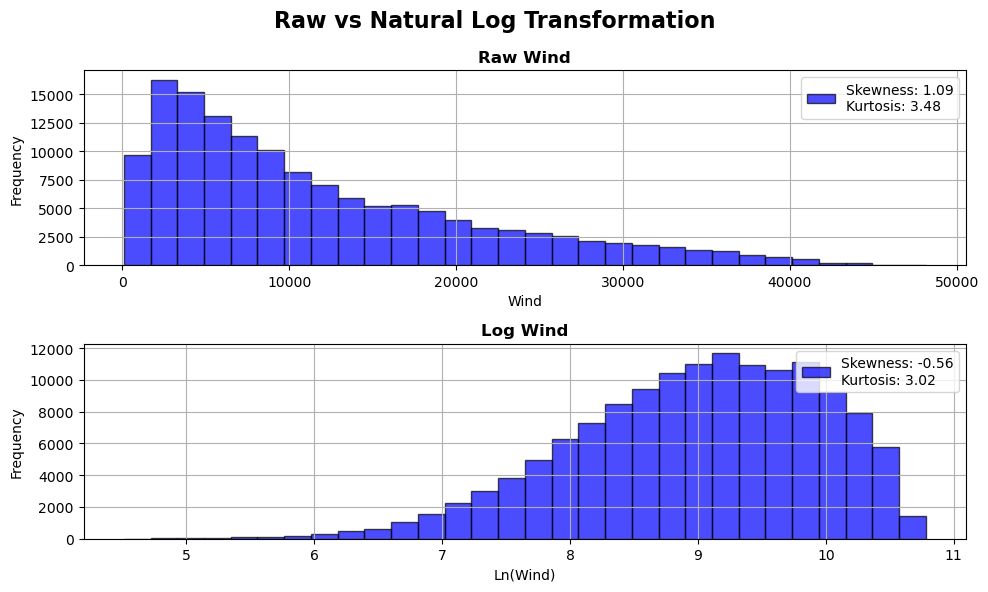

In [22]:
plot_configs_wind = {
    "wind": {
        "title": "Raw Wind",
        "label": "Wind",
        "color": "blue",
    }
}    
plot_configs_wind_log = {
    "wind_log": {
        "title": "Log Wind",
        "label": "Ln(Wind)",
        "color": "blue"
    }
}
plot_configs_wind.update(plot_configs_wind_log)

df["wind_log"] = np.log(df["wind"])
plot_histograms(df[plot_configs_wind.keys()], title="Raw vs Natural Log Transformation", figsize=(10, 6), plot_configs=plot_configs_wind)

The log transformation for wind data effectively compresses the range of values to between 4 and 11, while slightly reducing both skewness and kurtosis, resulting in a more balanced distribution.

### **Square Root Transformation**
The square root transformation, similar to the log transformation, reduces skewness but is applicable to non-negative data (including values equal to 0). It compresses large values while having a milder effect than the log transformation, making it ideal for moderately skewed distributions.

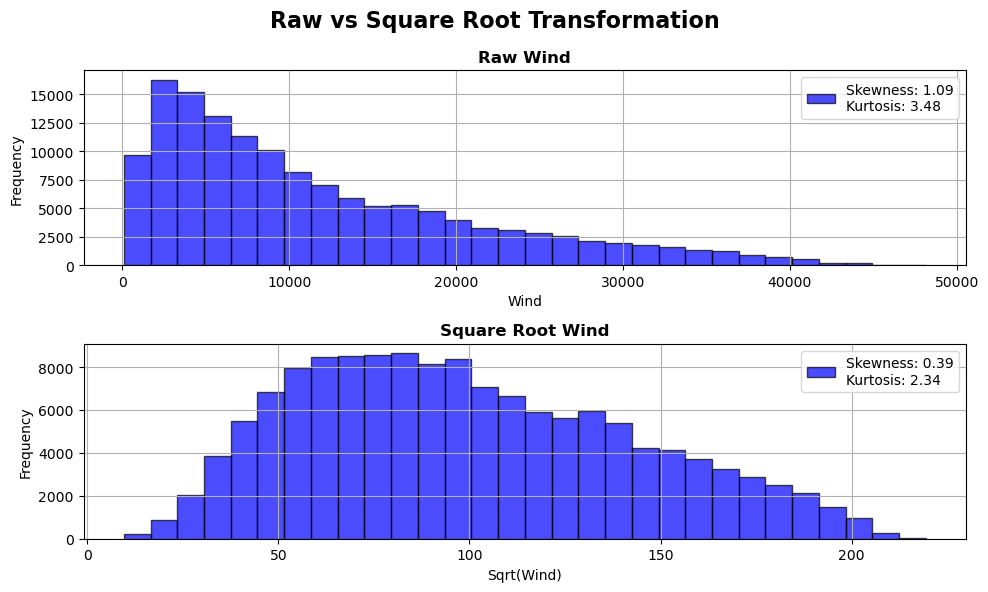

In [23]:
plot_configs_wind_sqrt = {
    "wind_sqrt": {
        "title": "Square Root Wind",
        "label": "Sqrt(Wind)",
        "color": "blue"
    }
}
plot_configs_wind.update(plot_configs_wind_sqrt)

df["wind_sqrt"] = np.sqrt(df["wind"])
plot_histograms(df[["wind", "wind_sqrt"]], title="Raw vs Square Root Transformation", figsize=(10, 6), plot_configs=plot_configs_wind)

Since wind data is moderalty skewed, the square root transformation performs slightly better than the log transformation.

### **Box-Cox Transformation**

The Box-Cox transformation is a widely used technique for normalizing data to meet the assumptions of statistical models. It applies a power transformation controlled by a parameter, lambda ($\lambda$). The value of $\lambda$ determines the type of transformation applied: 

- When $\lambda = 0$, the transformation is logarithmic.
- For $\lambda \neq 0$, it applies a power transformation that can range from square root to inverse transformations.

This flexibility makes Box-Cox particularly effective for handling skewed data and stabilizing variance. The formula for the transformation is:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\ln(y), & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $y$ is the original data (must be positive).
- $\lambda$ is the transformation parameter.

This transformation ensures that the data becomes closer to a normal distribution, improving the performance of statistical and machine learning models.

Box-Cox Lambdas: {'wind': np.float64(0.23877356336940433)}


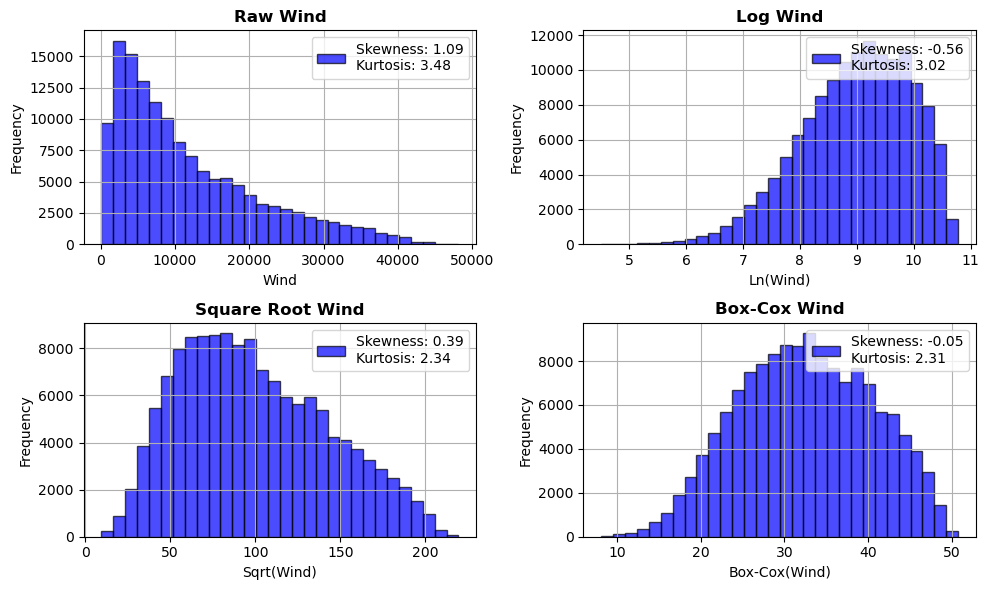

In [24]:
def apply_boxcox(df, columns, espilon=1e-3):
    """
    Apply Box-Cox transformation with correction for 0 values to specified columns in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to apply Box-Cox transformation.
        
    Returns:
        pd.DataFrame: DataFrame with transformed columns and Box-Cox lambdas.
    """
    boxcox_lambdas = {}

    for col in columns:
        transformed_col = df[col]
        if (df[col] <= 0).any():
            transformed_col += espilon
        df[f"{col}_boxcox"], boxcox_lambdas[col] = boxcox(transformed_col)

    return df, boxcox_lambdas

plot_configs_wind_boxcox = {
    "wind_boxcox": {
        "title": "Box-Cox Wind",
        "label": "Box-Cox(Wind)",
        "color": "blue"
    }
}
plot_configs_wind.update(plot_configs_wind_boxcox)

df, boxcox_lambdas = apply_boxcox(df, ["wind"])
print("Box-Cox Lambdas:", boxcox_lambdas)
plot_histograms(df[plot_configs_wind.keys()], figsize=(10, 6), plot_configs=plot_configs_wind)

The Box-Cox transformation is the most effective in normalizing the wind distribution, achieving the lowest skewness and kurtosis among the tested methods.

#### **Filter Remaining Outliers with the Z-score**

Now that the distribution is closer to normal after winsorization, we apply the **Z-score** to identify and filter any remaining outliers. This step ensures that any residual extreme values, which could still impact the model, are flagged and handled appropriately.

In [25]:
z_scores = zscore(df["wind_boxcox"])
wind_outliers = z_scores.abs() > 3
df.loc[wind_outliers, "wind_boxcox"]

Date
2020-08-08 07:45:00    8.172415
2020-08-08 08:00:00    8.108419
2020-08-08 08:15:00    8.266473
2021-06-26 07:15:00    8.297328
2021-06-26 07:30:00    8.235372
2021-06-26 07:45:00    8.477541
2021-06-26 08:00:00    8.506794
Name: wind_boxcox, dtype: float64

In [26]:
df = df.loc[~wind_outliers]

### **Addressing the Prevalence of Zero Observations in Solar Data**

Solar data contains a high number of zero observations, especially during nighttime or overcast conditions. These zeros can heavily influence the distribution and statistical properties of the data, potentially affecting model performance.

### **Yeo-Johnson Transformation**

The Yeo-Johnson transformation extends the Box-Cox method to handle both positive and non-positive data, making it suitable for datasets with zeros or negative values. Like Box-Cox, it applies a power transformation controlled by a parameter, $\lambda$, but can adapt to a broader range of data types.

The formula is:

$$
T(x, \lambda) =
\begin{cases} 
\frac{((x + 1)^\lambda - 1)}{\lambda}, & \text{if } \lambda \neq 0, x \geq 0 \\
\ln(x + 1), & \text{if } \lambda = 0, x \geq 0 \\
\frac{-((|x| + 1)^{2 - \lambda} - 1)}{2 - \lambda}, & \text{if } \lambda \neq 2, x < 0 \\
-\ln(|x| + 1), & \text{if } \lambda = 2, x < 0
\end{cases}
$$

Where:
- $x$ is the data point.
- $\lambda$ is the transformation parameter.

This transformation reduces skewness and stabilizes variance, making data more suitable for modeling.

Box-Cox Lambdas: -0.01738396194266482


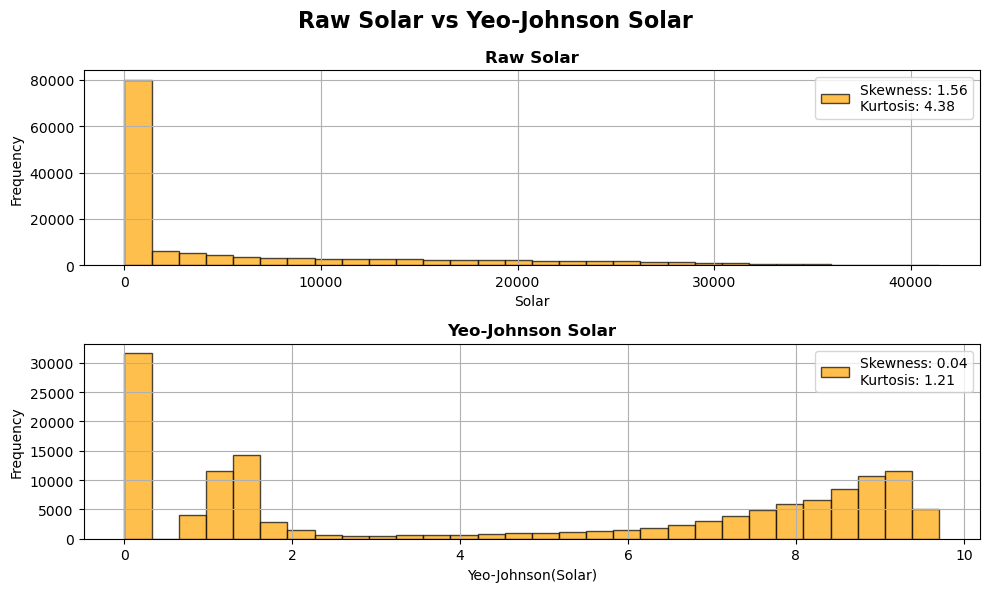

In [27]:
plot_configs_solar = {
    "solar": {
        "title": "Raw Solar",
        "label": "Solar",
        "color": "orange",
    },
    "solar_yeojohnson": {
        "title": "Yeo-Johnson Solar",
        "label": "Yeo-Johnson(Solar)",
        "color": "orange"
    }
}
df.loc[:, "solar_yeojohnson"] = 0.0

df.loc[:, "solar_yeojohnson"], boxcox_lambdas = yeojohnson(df["solar"].copy())
print("Box-Cox Lambdas:", boxcox_lambdas)
plot_histograms(df[plot_configs_solar.keys()], title="Raw Solar vs Yeo-Johnson Solar", figsize=(10, 6),plot_configs=plot_configs_solar)

While the transformation significantly reduces skewness (from **1.56** to **0.04**) and kurtosis (from **4.38** to **1.21**), making the distribution closer to normal, it fails to address the large concentration of near-zero values. This obsevration sugguests that further data-preprocessing, such as separating daytime and nighttime data, might be necessary.

#### **Daytime vs Night-time Solar Power Generation**

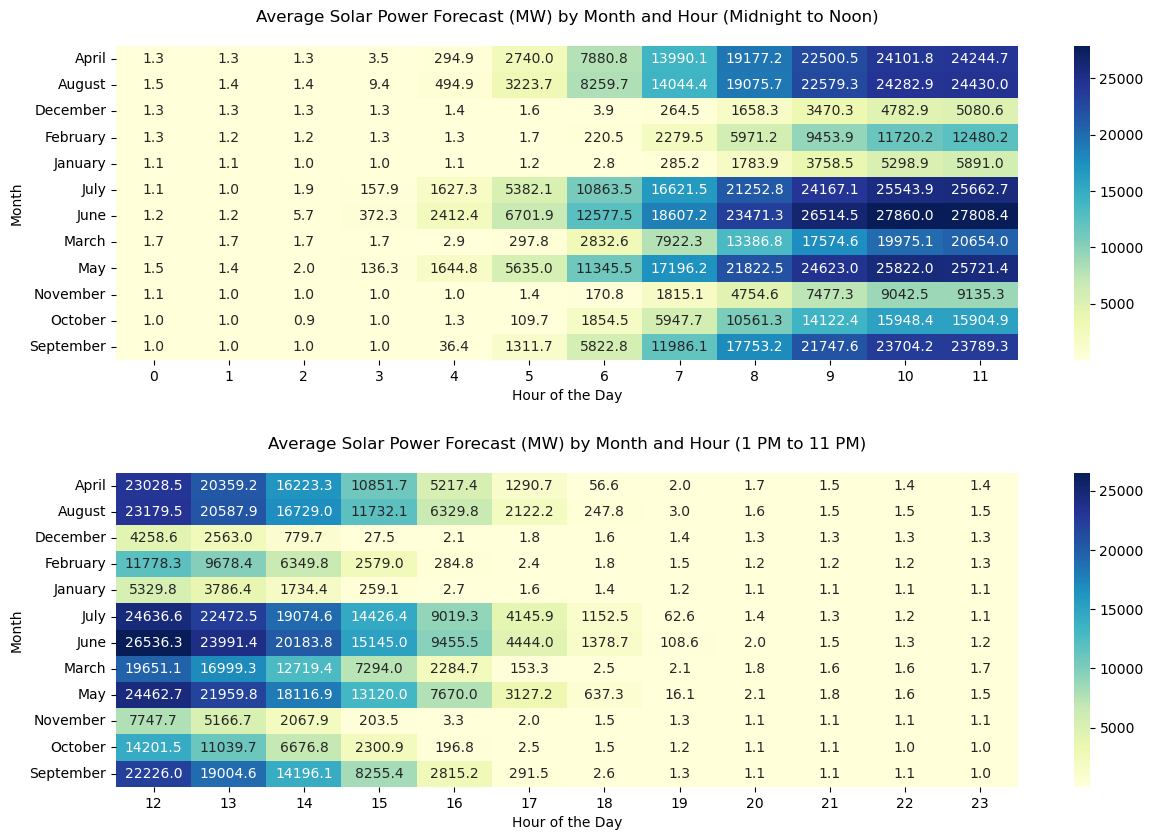

In [28]:
df.loc[:, "Month"] = pd.Categorical(df.index.month_name(), categories=MONTHS, ordered=True)
df.loc[:, "Hour"] = df.index.hour

pivot_table = df.pivot_table(
    values="solar", 
    index="Month", 
    columns="Hour", 
    aggfunc="mean",
    observed=False
)

# Split into two parts: midnight to noon and 1 PM to 11 PM
pivot_table_am = pivot_table.loc[:, :11]
pivot_table_pm = pivot_table.loc[:, 12:23]

# Plotting AM hours (Midnight to Noon)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plt.tight_layout(h_pad=6)

sns.heatmap(pivot_table_am, cmap="YlGnBu", annot=True, fmt=".1f", cbar=True, ax=ax1)
ax1.set_title("Average Solar Power Forecast (MW) by Month and Hour (Midnight to Noon)", y=1.05)
ax1.set_xlabel("Hour of the Day")
ax1.set_ylabel("Month")

sns.heatmap(pivot_table_pm, cmap="YlGnBu", annot=True, fmt=".1f", cbar=True, ax=ax2)
ax2.set_title("Average Solar Power Forecast (MW) by Month and Hour (1 PM to 11 PM)", y=1.05)
ax2.set_xlabel("Hour of the Day")
ax2.set_ylabel("Month")
plt.show()

In [29]:
solar_threshold = 10  # Solar power threshold (MW)
daytime_hours = {}

for month in MONTHS:
    monthly_data = df[df["Month"] == month]
    hourly_avg = monthly_data.groupby(monthly_data.index.hour)["solar"].mean()
    daytime_start = hourly_avg[hourly_avg > solar_threshold].index.min()
    daytime_end = hourly_avg[hourly_avg > solar_threshold].index.max()
    daytime_hours[month] = list(range(daytime_start, daytime_end + 1))
    
daytime_hours

{'January': [7, 8, 9, 10, 11, 12, 13, 14, 15],
 'February': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'March': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'April': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 'May': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'June': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'July': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'August': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 'September': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'October': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'November': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'December': [7, 8, 9, 10, 11, 12, 13, 14, 15]}

However, since the scale is influenced by the entire dataset, complementing this with visual validation ensures that the derived daytime hours are reasonable are consistent across the years.

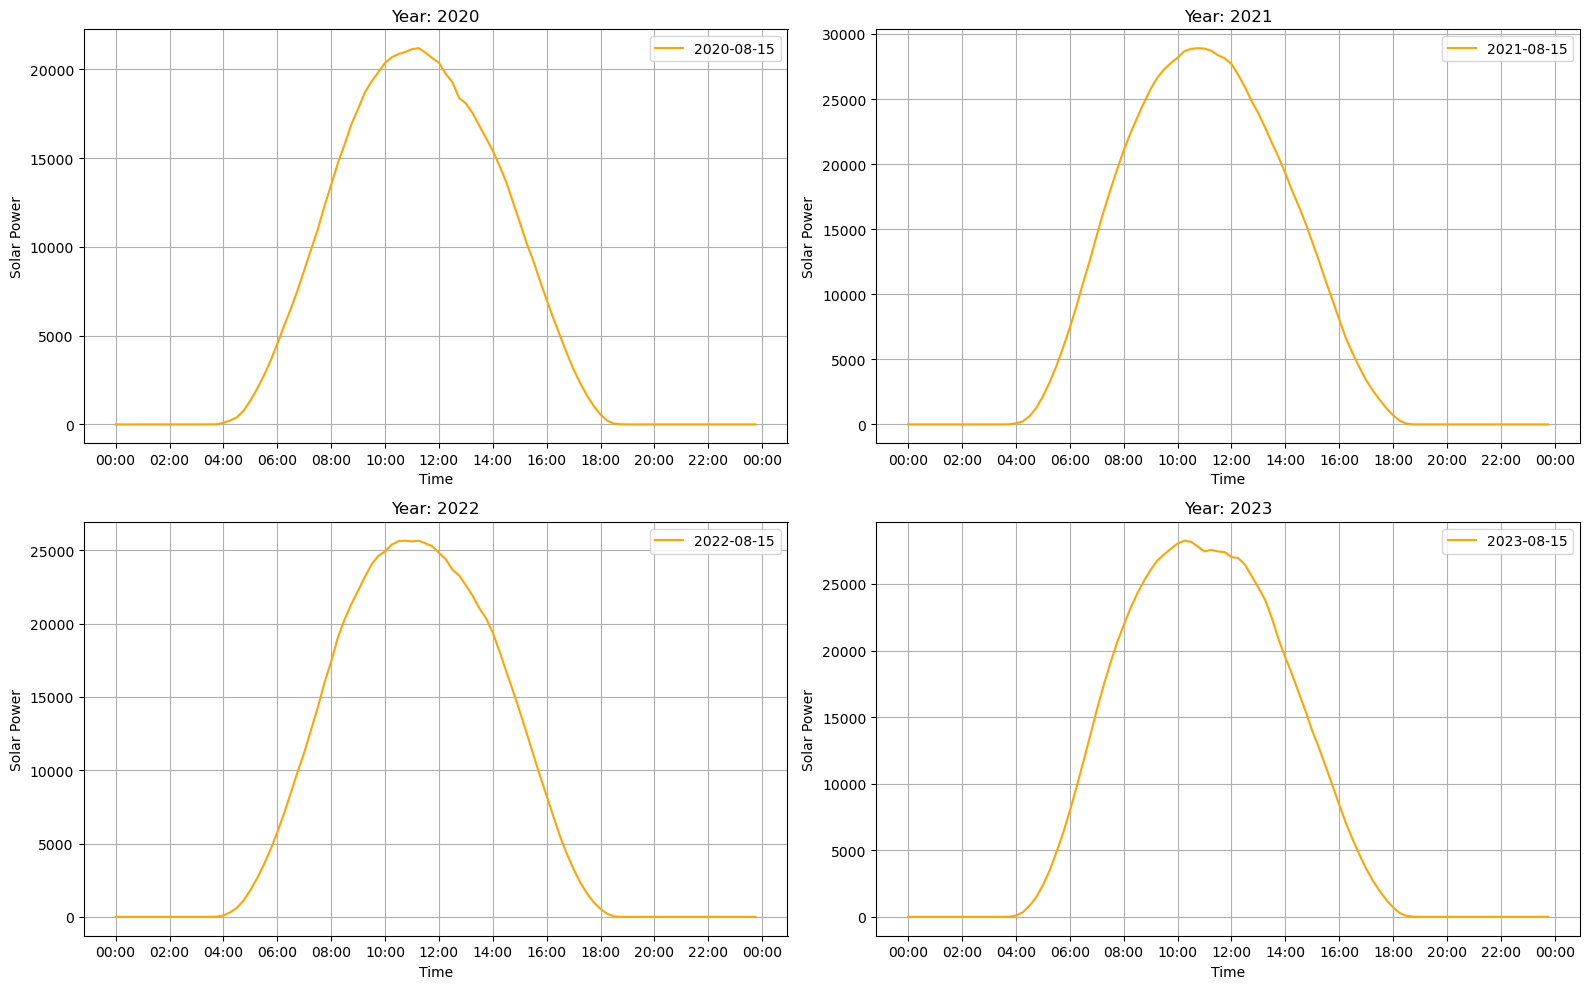

In [30]:
# Specify the day and month to analyze across years
day = 15
month = 8

specific_day_month_data = df[(df.index.day == day) & (df.index.month == month)]
years = df.index.year.unique()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, year in enumerate(years):
    year_data = specific_day_month_data[specific_day_month_data.index.year == year]
    axes[idx].plot(year_data.index, year_data["solar"], label=f"{year}-{month:02d}-{day}", color="orange")
    axes[idx].set_title(f"Year: {year}")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Solar Power")
    axes[idx].grid(True)
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axes[idx].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[idx].legend()

plt.tight_layout()
plt.show()

Despite the intensity varying across the years, the start and end day times are consistent across the years, by replacing `month` wiht other month values you will see that the observation is the same.

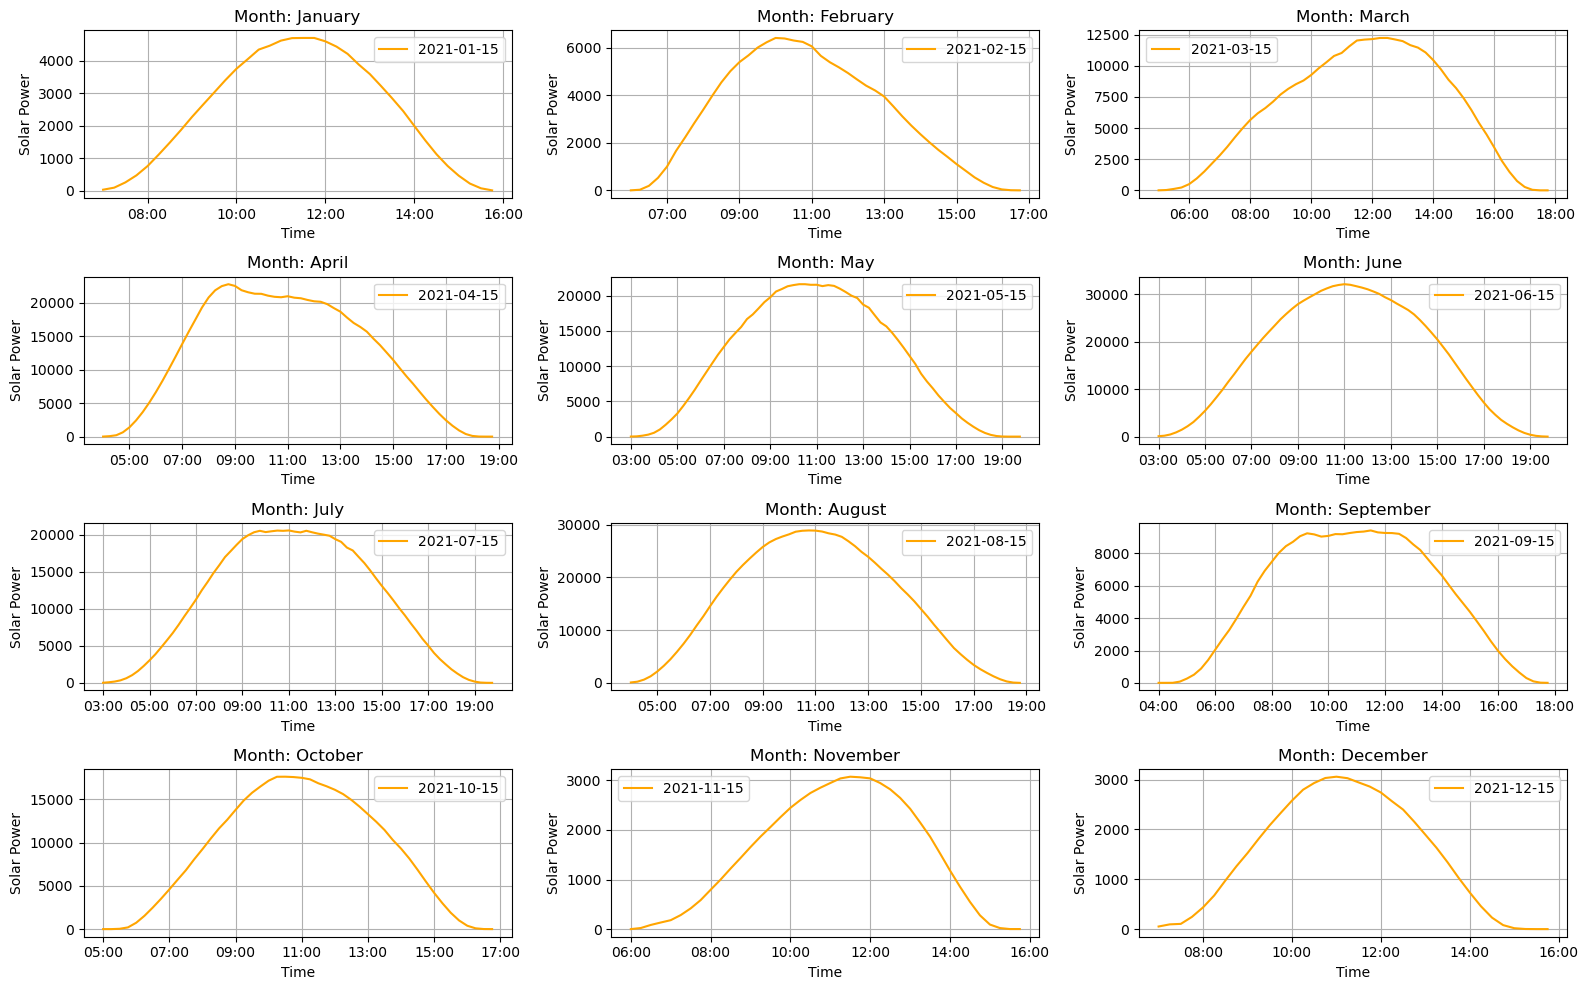

In [31]:
def split_daytime_nighttime(df, daytime_hours):
    """
    Splits a DataFrame into daytime and nighttime subsets based on specified hours for each month.

    Args:
        df (pd.DataFrame): The input DataFrame. Must contain 'Month' and 'Hour' columns.
        daytime_hours (dict): A dictionary mapping each month to its daytime hours.
                              Example: {"January": [7, 8, 9, 10, ...], "February": [...], ...}

    Returns:
        tuple: A tuple containing two DataFrames (daytime, nighttime).
    """
    data = df.copy()
    
    if 'Month' not in df.columns:
        data["Month"] = data.index.month_name()
    if 'Hour' not in df.columns:
        data["Hour"] = data.index.hour

    def check_is_daytime(row):
        month = row['Month']
        hour = row['Hour']
        return hour in daytime_hours.get(month, [])
    
    is_daytime = data.apply(check_is_daytime, axis=1)
    
    daytime = data[is_daytime].copy()
    nighttime = data[~is_daytime].copy()

    return daytime, nighttime


daytime, nighttime = split_daytime_nighttime(df, daytime_hours)

# Specify the year and the day to analyze
year = 2021
day = 15

specific_year_data = daytime[(daytime.index.year == year) & (daytime.index.day == day)]

months = range(1, 13)
fig, axes = plt.subplots(4,3, figsize=(16, 10), sharey=False)
axes = axes.flatten()

for idx, month in enumerate(months):
    month_data = specific_year_data[specific_year_data.index.month == month]
    axes[idx].plot(month_data.index, month_data["solar"], label=f"{year}-{month:02d}-{day}", color="orange")
    axes[idx].set_title(f"Month: {month_data.index[0].strftime('%B')}")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Solar Power")
    axes[idx].grid(True)
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axes[idx].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=0)
    axes[idx].legend()

plt.tight_layout()
plt.show()

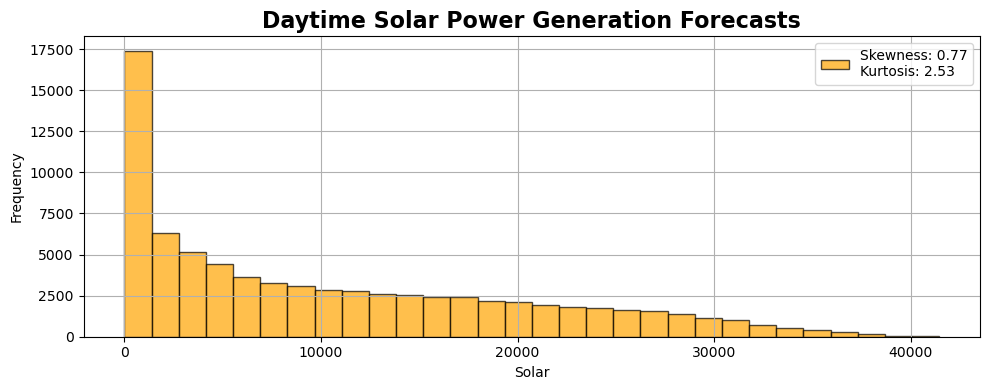

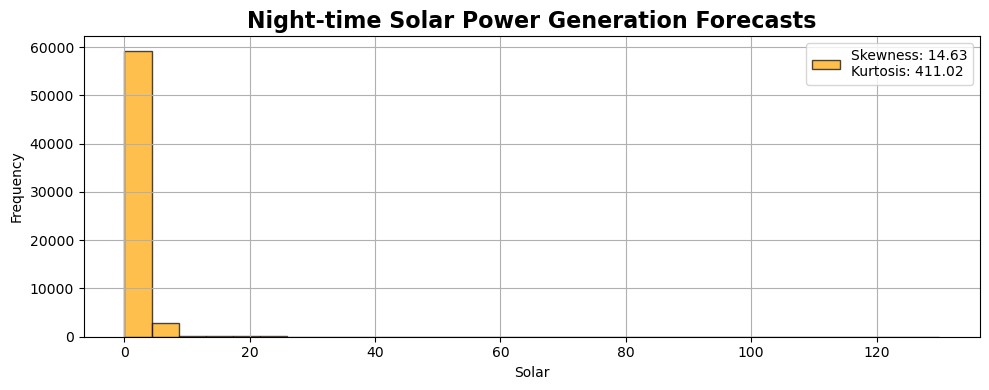

In [32]:
plot_configs_solar_daytime = {
    "solar": {
        "title": "Solar Daytime",
        "label": "Solar",
        "color": "orange"
    }
}
plot_configs_solar_nighttime = plot_configs_solar_daytime.copy()
plot_configs_solar_nighttime["solar"]["title"] = "Solar Nighttime"

plot_histograms(daytime["solar"], title="Daytime Solar Power Generation Forecasts", figsize=(10, 4), plot_configs=plot_configs_solar_daytime)
plot_histograms(nighttime["solar"], title="Night-time Solar Power Generation Forecasts", figsize=(10, 4), plot_configs=plot_configs_solar_nighttime)

In [33]:
nighttime.sort_values("solar", ascending=False)["solar"].head(10)

Date
2021-08-01 03:45:00    130.0
2023-08-02 03:45:00    129.0
2022-08-02 03:45:00    124.0
2022-08-03 03:45:00    118.0
2020-08-01 03:45:00    106.0
2021-08-02 03:45:00    101.0
2023-08-03 03:45:00     98.0
2021-08-04 03:45:00     95.0
2021-08-03 03:45:00     93.0
2021-08-05 03:45:00     90.0
Name: solar, dtype: float64

The 10 largest noises are observed early during **August 2023** just before the day time strating at **4:00 am**, in that case we can simply filter them and reduce all of them to 0.

In [34]:
daytime.loc[daytime["solar"] == 0, "solar"]

Date
2020-01-02 15:45:00    0.0
2020-01-03 15:45:00    0.0
2020-01-04 15:45:00    0.0
2020-01-05 15:45:00    0.0
2020-01-08 15:45:00    0.0
                      ... 
2021-12-27 15:45:00    0.0
2021-12-28 15:45:00    0.0
2021-12-29 15:45:00    0.0
2021-12-30 15:45:00    0.0
2021-12-31 15:45:00    0.0
Name: solar, Length: 975, dtype: float64

The same goes during daytime where values reach exactly 0 near the end of daytime, howveer in contrast to night time it seems better to kepe them as they are and instead of using Box-Cox we opt for Yeo-Johnson.

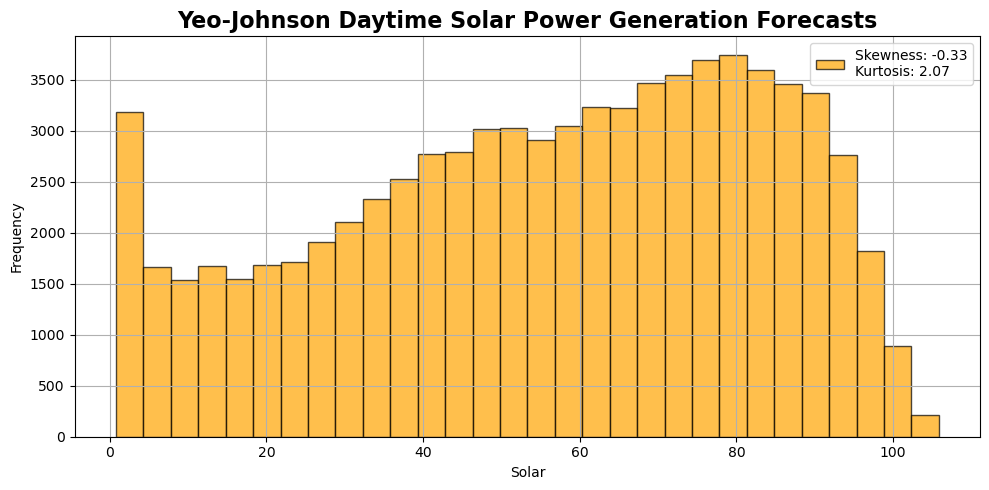

In [35]:
def clean_solar(df, daytime, nighttime):
    # Filter solar noise during night-time
    nighttime.loc[nighttime.index, "solar_cleaned"] = 0.0

    # Perform Yeo-Johnson on daytime
    daytime_solar_yeojohnson, _ = yeojohnson(daytime["solar"].copy())
    daytime.loc[daytime.index, "solar_cleaned"] = daytime_solar_yeojohnson

    df.loc[:, "solar_cleaned"] = 0.0
    df.loc[daytime.index, "solar_cleaned"] = daytime["solar_cleaned"]
    df.loc[nighttime.index, "solar_cleaned"] = nighttime["solar_cleaned"]

    return df

df = clean_solar(df, daytime, nighttime)

plot_configs_solar_daytime["solar_cleaned"] = plot_configs_solar_daytime.pop("solar")
plot_histograms(df.loc[df["solar_cleaned"] > 0, "solar_cleaned"], title="Yeo-Johnson Daytime Solar Power Generation Forecasts", figsize=(10, 5), plot_configs=plot_configs_solar_daytime)

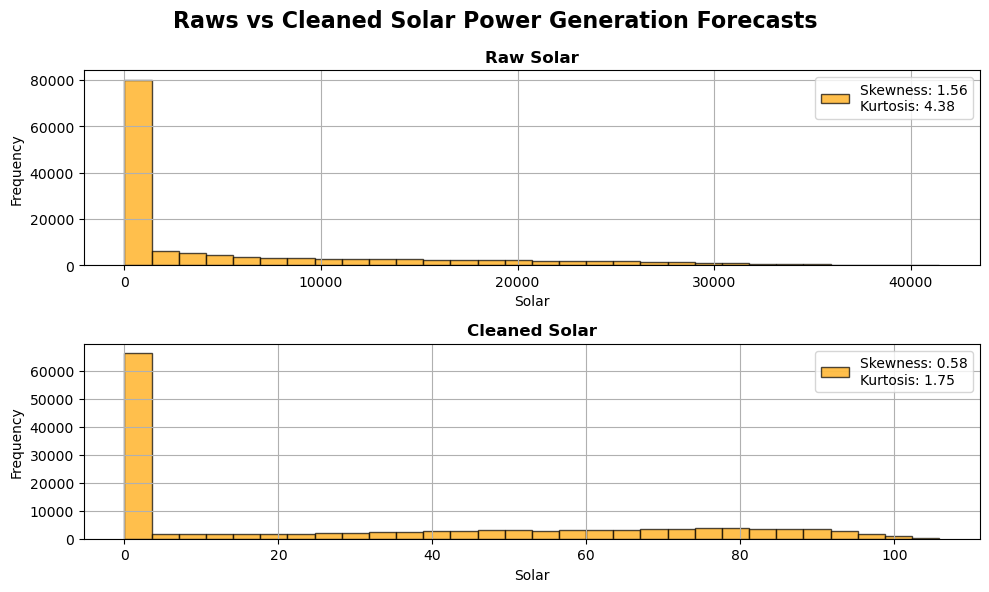

In [36]:
plot_configs_solar.update(plot_configs_solar_daytime)
plot_configs_solar["solar_cleaned"]["title"] = "Cleaned Solar"
if "solar_yeojohnson" in plot_configs_solar:
    del plot_configs_solar["solar_yeojohnson"]

plot_histograms(df[plot_configs_solar.keys()], title="Raws vs Cleaned Solar Power Generation Forecasts", figsize=(10, 6), plot_configs=plot_configs_solar)

The cleaned solar power generation forecasts have now a reasonable range and show a lower skewness and kurtosis.

In [37]:
df.to_csv("data_cleaned.csv")